# t-SNE (t-distributed Stochastic Neighbor Embedding)

- 가까운 이웃 객체들과의 거리 정보를 잘 보존하는 것이 멀리 떨어진 객체들과의 거리 정보를 보존하는 것 보다 중요함
- SNE는 local pairwise distance를 확정적(deterministic like LLE)이 아닌 확률적(probabilistic)으로 정의함
- 원래 차원과 임베딩 된 이후의 저차원에서 두 객체간의 이웃 관계는 잘 보존이 되어야 함
- 하기와 같이 고차원과 저차원에서의 확률 분포를 구한 후, 두 분포의 유사도를 구해 근사한다. 유사도는 KL-Divergence를 사용한다.
  - p_j|i = 고차원에서 객체 i가 객체 j를 이웃으로 택할 확률
  - q_j|i = 저차원에서 객체 i가 객체 j를 이웃으로 택할 확률
- 기본적으로 고차원에서는 Gaussian 분포를, 저차원에서는 t분포를 사용한다.
  - Gaussian 분포를 사용할 시에, Radius of gaussian을 구해야 하는데, 이때 원하는 수준의 entropy(perplexity)를 hyper-parameter로 사용하여, 적합한 Radius를 결정한다.

- Reference Code
  - Created by Laurens van der Maaten on 20-12-08. Copyright (c) 2008 Tilburg University. All rights reserved.

In [1]:
import numpy as np
import pylab

# Calculate Perplexity and P Values for each row
- 고차원에서의 p값을 구하고, Pereplexity H를 계산한다.
- 이를통해 적절한 Sigma로 P를 구할 수 있다.

In [2]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P



# X to P
- Raw Data X로부터 P값을 구한다.
- 그리고 H로 부터 Sigma값을 계산한다.

In [3]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

# PCA
- 기본적으로 고차원의 image vector를 PCA로 차원을 축소하고, t-SNE를 진행한다. (raw(highest) dimension에서의 t-SNE 자체가 시간이 너무 오래걸림)
- 본 논문에서도 해당 Trick을 사용함

In [5]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

# t-SNE (Main Algorithm)

1) PCA를 통해 1차적으로 차원 축소 진행
2) Perplexity를 통해 sigma와 함꼐 P Matrix를 구한다.
3) 구해진 P Matrix를 고정하고, 반복적으로 Q Matrix를 계산하며 KL-Divergence를 통해 계산된 Cost값의 미분값을 계산한다.
4) 계산된 미분값으로 Y값을 계속 반복적 업데이트 한다.

In [10]:
def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.

        Input
            X : 변환하고자 하는 Raw Data (High Dimensional Data)
            no_dims : 축소하려는 차원 값
            initial_dims : 기본 Raw Data를 PCA로 변환하고자 하는 차원 (1차적으로 PCA를 돌림)
            perplexity : Radius of Gaussian을 결정하기 위한, Entropy값
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    # 1. P Matrix를 구한다. (고차원의 Gaussian Fitting된 분포)
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        # 2. Q Matrix를 구한다. (저차원에서 t-Distribution으로 Fitting해야 할 분포)
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        # 3. Gradient를 계산한다.
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain

        # 4. Gradient(dC/dy)를 통하여 Y값(좌표값)을 업데이트 해 준다.
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


# Main

- MNIST 2,500개의 784(28*28) Dimension의 Raw Data Digits을 사용하여 t-SNE를 수행한다.

Run Y = tsne.tsne(X, no_dims, initial_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.660890
Iteration 20: error is 20.927234
Iteration 30: error is 17.687391
Iteration 40: error is 16.670417
Iteration 50: error is 16.411294
Iteration 60: error is 16.269688
Iteration 70: error is 16.150060
Iteration 80: error is 16.041537
Iteration 90: error is 15.968405
Iteration 100: error is 15.930314
Iteration 110: error is 2.325002
Iteration 120: error is 2.095993
Iteration 130: error is 1.913795
Iteration 140: error is 1.773379
Iteration 150: error is 1.664720
Iteration 160: error is 1.579021
Iteration 170: error 

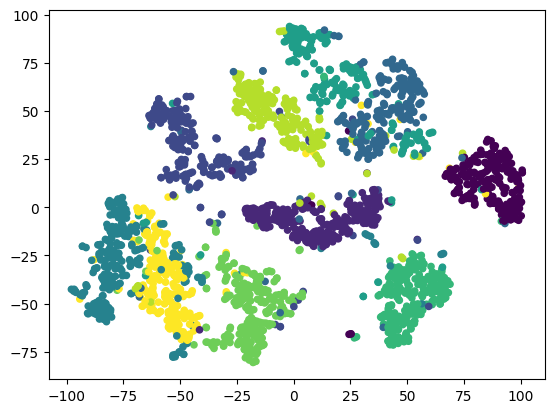

In [11]:
print("Run Y = tsne.tsne(X, no_dims, initial_dims, perplexity) to perform t-SNE on your dataset.")
print("Running example on 2,500 MNIST digits...")

X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")

Y = tsne(X, 2, 50, 20.0)

pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show()